<a href="https://colab.research.google.com/github/HS587885/Mini_Project/blob/main/LSTM_B_max_meta_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import re
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,LSTM,Dense, Bidirectional, GRU
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

%%bash
apt-get update
apt-get install g++ openjdk-8-jdk python-dev python3-dev
pip3 install JPype1
pip3 install konlpy

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:5 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:12 http://security.ubuntu.com/ubuntu bionic-security InRelease
Reading package lists...
Reading package lists...
Building dependency tree...
Rea

In [ ]:
%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

env: JAVA_HOME="/usr/lib/jvm/java-8-openjdk-amd64"


In [ ]:
%%bash
bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
pip3 install /tmp/mecab-python-0.996


mecab-ko is already installed
mecab-ko-dic is already installed
mecab-python is already installed
Done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /tmp/mecab-python-0.996
  Created wheel for mecab-python: filename=mecab_python-0.996_ko_0.9.2-cp37-cp37m-linux_x86_64.whl size=141806 sha256=393ebdbd0e1f39afa3c52299d514f70ba32d3248f4e0bd238de79a40d778b60f
  Stored in directory: /root/.cache/pip/wheels/40/7b/9f/2922869bef86c3354ae7034f7a3647c573ee1997c2dad0290a
Failed to build mecab-python
  Attempting uninstall: mecab-python
    Found existing installation: mecab-python 0.996-ko-0.9.2
    Uninstalling mecab-python-0.996-ko-0.9.2:
      Successfully uninstalled mecab-python-0.996-ko-0.9.2
    Running setup.py install for mecab-python: started
    Running setup.py install for mecab-python: finished with status 'done'


  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  DEPRECATION: mecab-python was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [ ]:
bmax = pd.read_excel('/content/B-max_meta.xlsx')
print(bmax.head())
print(len(bmax))


                                             comment  제품에 대한 긍부정2
0                 드디어샀다!~ . 비맥스메타~ 찾으러산만리~ 육체피로야안녕\n            1
1   #남포동약국거리 그중에서도 유명한 세x약국에서 영양제 구입 #빈블리 #영양제 #텐...            1
2  //;// #비맥스메타  #비맥스비비   #비맥스성지 #비맥스최저가 #영양제 #텐텐...            1
3  오늘의루트  안산기흥안산안양광명안산 잘 돌아 댕겼다 ㅋㅋㅋㅋㅋㅋ . . . #안산 ...            3
4  #뽀이약사_복약지도 비타민B . ️지난번에 이어서 두번째 피드입니다 . . #비타민...            1
500


In [ ]:
bmax.head()
bmax.rename(columns= {'제품에 대한 긍부정2':'label'}, inplace= True)

In [ ]:
bmax['label'] = bmax['label'].replace(3, 2)

In [ ]:
bmax['comment'].nunique(), bmax['label'].nunique()


(492, 2)

In [ ]:
train_data, test_data = train_test_split(bmax, test_size = 0.1, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 450
테스트용 리뷰의 개수 : 50


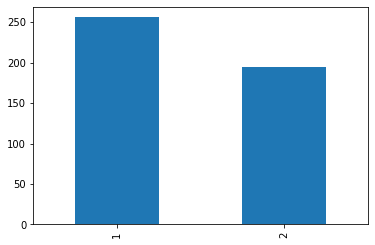

In [ ]:
train_data['label'].value_counts().plot(kind = 'bar')

In [ ]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      1    256
1      2    194


In [ ]:
train_data['comment'] = train_data['comment'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['comment'].replace('', np.nan, inplace=True)
train_data = train_data.dropna(how='any') # Null 값 제거
print(train_data.isnull().sum())

comment    0
label      0
dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [ ]:
test_data.drop_duplicates(subset = ['comment'], inplace=True) # 중복 제거
test_data['comment'] = test_data['comment'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['comment'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [ ]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', 
'를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게', '만', '게임', '겜', '되', '음', '면'
'가탄', '태전동', '칠곡','장영실', '에디슨','양제', '보드게임','하하호호', '지금',
             '실버','로나', '골드','우루사','오늘', '그램', '우리', '차이', '그램',  '하나', '일동제약', '김혜윤', '강동호'
             '박카스', '이진혁',' 공진단', '세라', '진짜','주년''문재인', '대통령','시우민', '우루사', '비콤','마멜공쥬',
            '현미', '곤약', '밥', '고구마', '치즈', '롤', '스테이크', '물', '물', '컵','띵가띵', '놀고잇엇어','길용우', '배우', '까스', '명수',
            '자가', '키트', '코로나', '와인', '모주', '코스피', '종목', '일동', '전속계약', '오윤수', '씨앤코', '전속계약', 
             '김규리', '최', '희서', '한솥', '밥', '배우', '조우진', '포벨', '종근당', '임팩타민', '아시', '맥스'

]


In [ ]:
train_data['comment']

72         간만에 영양제 샷  점심  오메가 알 마그네슘 알 판토텐산 알 나아신 알 비맥스메
182         정부재난지원금사용처 경기재난지원금 구리지역화폐 정부재난지원금 비맥스메타 비맥스 
131             운동하려면 건강해야지     영양제 비타민 헬스타그램 헬린이 종합비타민 
410    안녕하세요   오늘은 녹십자의 대표 종합영양제 비맥스의 시리즈인 비맥스골드 비맥스액...
193     비맥스 카카오톡이모티콘 이모티콘으로 가수 비를 보낼수 있습니다 다운후 유효기간 있어요 
                             ...                        
106    녹용이 들어간 비맥스 에버 출시  기존 제품의 단점은 개선하고 주요 보약 성분까지 넣어 
270    비타민 비맥스 비맥스메타 부작용 후기 영양제  안녕하세요 청년봉달입니다오늘도 광고없...
348           공유 고함량 비타민군 함유 종합비타민제 종 전격 리뷰 해봤습니다 비맥스 메타
435                                        흰쥐의 해 년을 맞이하기
102                창곤이형이 추천해준 비멕스메타  상현역 기분좋은약국 친절한약사 추천
Name: comment, Length: 446, dtype: object

In [ ]:
mecab = Mecab() 

train_data['tokenized'] = train_data['comment'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
test_data['tokenized'] = test_data['comment'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [ ]:
negative_words = np.hstack(train_data[train_data.label == 2]['tokenized'].values)
#middlePoint_words = np.hstack(train_data[train_data.label == 3]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [ ]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('비타민', 578), ('있', 523), ('약국', 511), ('비', 437), ('먹', 318), ('로', 282), ('습니다', 279), ('으로', 264), ('어', 235), ('시', 221), ('제품', 205), ('메타', 188), ('해', 159), ('성분', 154), ('것', 152), ('에서', 148), ('면', 147), ('좋', 143), ('적', 142), ('기', 140)]


In [ ]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('비', 854), ('먹', 688), ('비타민', 679), ('있', 678), ('메타', 534), ('어', 414), ('약국', 410), ('로', 371), ('으로', 351), ('시', 291), ('좋', 284), ('었', 271), ('는데', 261), ('기', 261), ('에서', 261), ('면', 239), ('나', 230), ('것', 230), ('습니다', 228), ('보', 226)]


In [ ]:
# middlePoint_word_count =  Counter(middlePoint_words)
# print(middlePoint_word_count.most_common(20))

긍정 리뷰의 평균 길이 : 167.9296875
부정 리뷰의 평균 길이 : 162.18421052631578


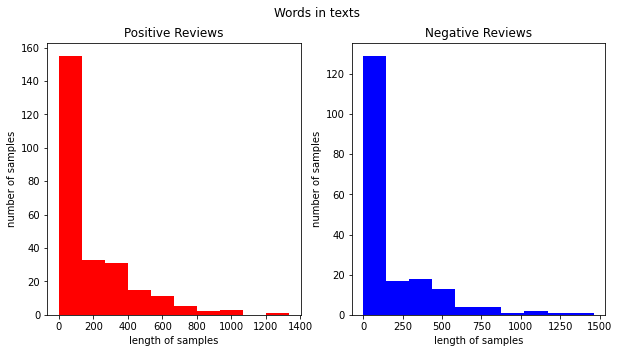

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==2]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [ ]:
# fig,(ax1) = plt.subplots(1,figsize=(10,5))
# text_len = train_data[train_data['label']==3]['tokenized'].map(lambda x: len(x))
# ax1.hist(text_len, color='green')
# ax1.set_title('Neutral Reviews')
# ax1.set_xlabel('length of samples')
# ax1.set_ylabel('number of samples')
# print('중립 리뷰의 평균 길이 :', np.mean(text_len))

In [ ]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었습니다. 이는 tokenizer.word_index를 출력하여 확인 가능합니다. 등장 횟수가 1회인 단어들은 자연어 처리에서 배제하고자 합니다. 이 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해봅시다.

In [ ]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 8113
등장 빈도가 1번 이하인 희귀 단어의 수: 3799
단어 집합에서 희귀 단어의 비율: 46.826081597436215
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.147347740667977


In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 4316


In [ ]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
print(X_train[:3])

[[1, 23, 1769, 378, 113, 36, 84, 36, 451, 36, 24, 1281, 36, 2, 164, 219], [2061, 692, 624, 198, 1282, 3127, 692, 624, 3128, 1398, 2470, 2061, 692, 624, 2, 7, 2], [310, 1399, 81, 1556, 23, 3, 1283, 144, 1, 76, 3]]


In [ ]:
print(X_test[:3])

[[240, 319, 3, 371, 1, 1021, 4095, 16, 396, 379, 1578, 4, 12, 88, 61, 14, 157, 18, 290, 147, 168, 1578, 61, 32, 97, 421, 6, 63, 1736, 290, 105, 3, 677, 43, 60, 1, 88, 18, 197, 2, 7, 32, 379, 877, 1152, 79, 30, 579, 241, 4, 12, 2, 7, 621, 240, 390, 424, 236, 1060, 518, 621, 240, 14, 758, 157, 18, 3, 18, 32, 2, 7, 190, 108, 99, 72, 3, 233, 782, 54, 230, 51, 93, 184, 169, 8, 397, 53, 165, 64, 81, 2911, 1, 58, 325, 1164, 190, 14, 3, 18, 290, 697, 12, 2, 164, 219, 285, 157, 18, 2, 7, 47, 290, 165, 64, 622, 79, 32, 1894, 157, 18, 241, 20, 253, 266, 60, 2, 7, 2, 340, 10, 5, 15, 191, 128, 258, 550, 45, 829, 735, 3, 1941, 27, 2671, 536, 68, 395, 40, 550, 45, 191, 225, 5, 9, 22, 170, 136, 67, 541, 236, 20, 22, 741, 45, 12, 80, 97, 421, 6, 14, 59, 28, 12], [395, 131, 61, 96, 49, 55, 24, 115, 995, 1, 1, 40, 1, 479, 74, 632, 100, 468, 1, 1, 2346], [1, 160, 1, 222, 576, 1, 148, 1, 80, 181, 94, 3226, 29, 10, 1, 1, 60, 1, 1, 1, 52, 1369, 809, 1, 1, 80, 1, 1, 1, 1738, 343, 751, 1, 1748, 88, 1, 194, 1, 

리뷰의 최대 길이 : 1462
리뷰의 평균 길이 : 165.48206278026905


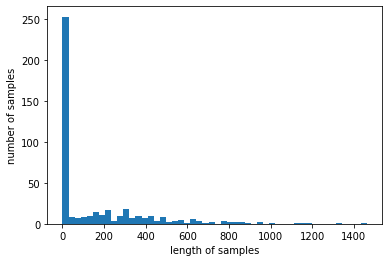

In [ ]:
# 패딩
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [ ]:
max_len = 1450
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 1450 이하인 샘플의 비율: 99.77578475336323


In [ ]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

# BiLSTM으로 감성 분류하기

In [ ]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Bidirectional(LSTM(hidden_units))) # Bidirectional LSTM을 사용
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
6/6 [==============================] - ETA: 0s - loss: nan - acc: 0.0169
Epoch 1: val_acc improved from -inf to 0.00000, saving model to best_model.h5
6/6 [==============================] - 5s 302ms/step - loss: nan - acc: 0.0169 - val_loss: nan - val_acc: 0.0000e+00
Epoch 2/15
6/6 [==============================] - ETA: 0s - loss: nan - acc: 0.0000e+00
Epoch 2: val_acc did not improve from 0.00000
6/6 [==============================] - 1s 153ms/step - loss: nan - acc: 0.0000e+00 - val_loss: nan - val_acc: 0.0000e+00
Epoch 3/15
6/6 [==============================] - ETA: 0s - loss: nan - acc: 0.0000e+00
Epoch 3: val_acc did not improve from 0.00000
6/6 [==============================] - 1s 149ms/step - loss: nan - acc: 0.0000e+00 - val_loss: nan - val_acc: 0.0000e+00
Epoch 4/15
6/6 [==============================] - ETA: 0s - loss: nan - acc: 0.0000e+00
Epoch 4: val_acc did not improve from 0.00000
6/6 [==============================] - 1s 152ms/step - loss: nan - acc: 0.000

In [ ]:
# embedding_dim = 100
# hidden_units = 128

# model = Sequential()
# model.add(Embedding(vocab_size, embedding_dim))
# model.add(GRU(hidden_units))
# model.add(Dense(2, activation='sigmoid'))

# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
# mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# history = model.fit(X_train, y_train, epochs=5, callbacks=[es, mc], batch_size=64, validation_split=0.2)

In [ ]:
loaded_model = load_model('best_model.h5')
print("테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

2/2 [==============================] - 1s 88ms/step - loss: nan - acc: 0.0000e+00
테스트 정확도: 0.0000


In [ ]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [ ]:
sentiment_predict('노잼 ..완전 재미 없음 ㅉㅉ')

50.48% 확률로 긍정 리뷰입니다.


In [ ]:
sentiment_predict('드래곤 ')

50.50% 확률로 긍정 리뷰입니다.
